<a href="https://colab.research.google.com/github/debjeet214/Python/blob/main/Speed_dating_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.1 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=7e14491682796bbf130f8b943567a6bcbf4e035b4ee3cf8254e496057d3e8108
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


**Ver 1 Code**

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.impute import SimpleImputer
from tpot import TPOTClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define utility functions
def evaluate_model(model, xtrain, xtest, ytrain, ytest):
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)

    # Ensure ytest and y_pred are integers
    ytest = ytest.astype(int)
    y_pred = y_pred.astype(int)

    print(f'Accuracy: {accuracy_score(ytest, y_pred)}')
    print(f'Precision: {precision_score(ytest, y_pred)}')
    print(f'Recall: {recall_score(ytest, y_pred)}')
    print(f'F1-Score: {f1_score(ytest, y_pred)}')
    print(f'Specificity: {(sum((ytest == 0) & (y_pred == 0)) / sum(ytest == 0))}')
    print(f'Cohen Kappa: {cohen_kappa_score(ytest, y_pred)}')
    print(f'ROC AUC: {roc_auc_score(ytest, y_pred)}')

# Load your dataset here
df = pd.read_csv('/Data Set.csv',  encoding='latin-1')

# Optionally, use a subset of the data if memory is an issue
df = df.sample(frac=0.1, random_state=0)

# Separate features and target
X = df.drop('match', axis=1)
y = df['match']

# Clean labels if necessary
y = y.astype(str).str.strip("b'").astype(int)

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler(with_mean=False))
        ]), X.select_dtypes(exclude=['object']).columns.tolist())
    ]
)

# Create a pipeline with preprocessing and scaling
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply the pipeline to the data
X_processed = pipeline.fit_transform(X)

# Convert the sparse matrix to a dense matrix
X_processed = X_processed.toarray()

# Split the data
xtrain, xtest, ytrain, ytest = train_test_split(X_processed, y, test_size=0.25, random_state=0)

# Hybrid Ensemble Model
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=0)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=0)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=50))
]

stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=500)
)

print("Hybrid Ensemble Model")
evaluate_model(stack, xtrain, xtest, ytrain, ytest)

# AutoML with TPOT
tpot = TPOTClassifier(verbosity=2, generations=3, population_size=20, random_state=0)
tpot.fit(xtrain, ytrain)
print("AutoML with TPOT")
evaluate_model(tpot.fitted_pipeline_, xtrain, xtest, ytrain, ytest)
tpot.export('tpot_best_pipeline.py')

# Deep Learning with Keras (Optional)
model = Sequential()
model.add(Dense(32, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(xtrain, ytrain, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

y_pred_keras = (model.predict(xtest) > 0.5).astype(int).flatten()  # Flatten the predictions
print("Deep Learning Model")
print(f'Accuracy: {accuracy_score(ytest, y_pred_keras)}')
print(f'Precision: {precision_score(ytest, y_pred_keras)}')
print(f'Recall: {recall_score(ytest, y_pred_keras)}')
print(f'F1-Score: {f1_score(ytest, y_pred_keras)}')
print(f'Specificity: {(sum((ytest == 0) & (y_pred_keras == 0)) / sum(ytest == 0))}')
print(f'Cohen Kappa: {cohen_kappa_score(ytest, y_pred_keras)}')
print(f'ROC AUC: {roc_auc_score(ytest, y_pred_keras)}')

Hybrid Ensemble Model


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:45:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:45:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:45:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
Specificity: 1.0
Cohen Kappa: 1.0
ROC AUC: 1.0


Optimization Progress:   0%|          | 0/80 [00:00<?, ?pipeline/s]

**Advanced Model with 10cross fold validation**

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.impute import SimpleImputer
from tpot import TPOTClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import wilcoxon  # Wilcoxon test
# 10-fold cross validation
from sklearn.model_selection import cross_val_predict, StratifiedKFold


# Define utility functions
def evaluate_model(model, xtrain, xtest, ytrain, ytest):
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)

# Define utility function with 10-fold cross-validation
def evaluate_model_with_cv(model, X, y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=cv)

    # Ensure ytest and y_pred are integers
    ytest = ytest.astype(int)
    y_pred = y_pred.astype(int)

    print(f'Accuracy: {accuracy_score(ytest, y_pred)}')
    print(f'Precision: {precision_score(ytest, y_pred)}')
    print(f'Recall: {recall_score(ytest, y_pred)}')
    print(f'F1-Score: {f1_score(ytest, y_pred)}')
    print(f'Specificity: {(sum((ytest == 0) & (y_pred == 0)) / sum(ytest == 0))}')
    print(f'Cohen Kappa: {cohen_kappa_score(ytest, y_pred)}')
    print(f'ROC AUC: {roc_auc_score(ytest, y_pred)}')


# Check for zero differences before performing Wilcoxon test
    if np.any(ytest != y_pred): # Check if there are any differences between ytest and y_pred
    # wilcoxon test
        stat, p_value = wilcoxon(ytest, y_pred)
        print(f'Wilcoxon Test Stat: {stat}, p-value: {p_value}')
    else:
        print("Wilcoxon test not performed: All predictions are identical.")

# Load your dataset here
df = pd.read_csv('/content/speeddating.csv',  encoding='latin-1')

# Optionally, use a subset of the data if memory is an issue
df = df.sample(frac=0.1, random_state=0)

# Separate features and target
X = df.drop('match', axis=1)
y = df['match']

# Clean labels if necessary
y = y.astype(str).str.strip("b'").astype(int)

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler(with_mean=False))
        ]), X.select_dtypes(exclude=['object']).columns.tolist())
    ]
)

# Create a pipeline with preprocessing and scaling
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply the pipeline to the data
X_processed = pipeline.fit_transform(X)

# Convert the sparse matrix to a dense matrix
X_processed = X_processed.toarray()

# Split the data
xtrain, xtest, ytrain, ytest = train_test_split(X_processed, y, test_size=0.25, random_state=0)

# Hybrid Ensemble Model
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=0)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=0)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=50))
]

stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=500)
)

print("Hybrid Ensemble Model")
evaluate_model(stack, xtrain, xtest, ytrain, ytest)

# AutoML with TPOT
tpot = TPOTClassifier(verbosity=2, generations=3, population_size=20, random_state=0)
tpot.fit(xtrain, ytrain)
print("AutoML with TPOT")
evaluate_model(tpot.fitted_pipeline_, xtrain, xtest, ytrain, ytest)
tpot.export('tpot_best_pipeline.py')

# Deep Learning with Keras (Optional)
model = Sequential()
model.add(Dense(32, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(xtrain, ytrain, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

y_pred_keras = (model.predict(xtest) > 0.5).astype(int).flatten()  # Flatten the predictions
print("Deep Learning Model")
print(f'Accuracy: {accuracy_score(ytest, y_pred_keras)}')
print(f'Precision: {precision_score(ytest, y_pred_keras)}')
print(f'Recall: {recall_score(ytest, y_pred_keras)}')
print(f'F1-Score: {f1_score(ytest, y_pred_keras)}')
print(f'Specificity: {(sum((ytest == 0) & (y_pred_keras == 0)) / sum(ytest == 0))}')
print(f'Cohen Kappa: {cohen_kappa_score(ytest, y_pred_keras)}')
print(f'ROC AUC: {roc_auc_score(ytest, y_pred_keras)}')

**ROC curve combined**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:01:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:01:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:01:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:01:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


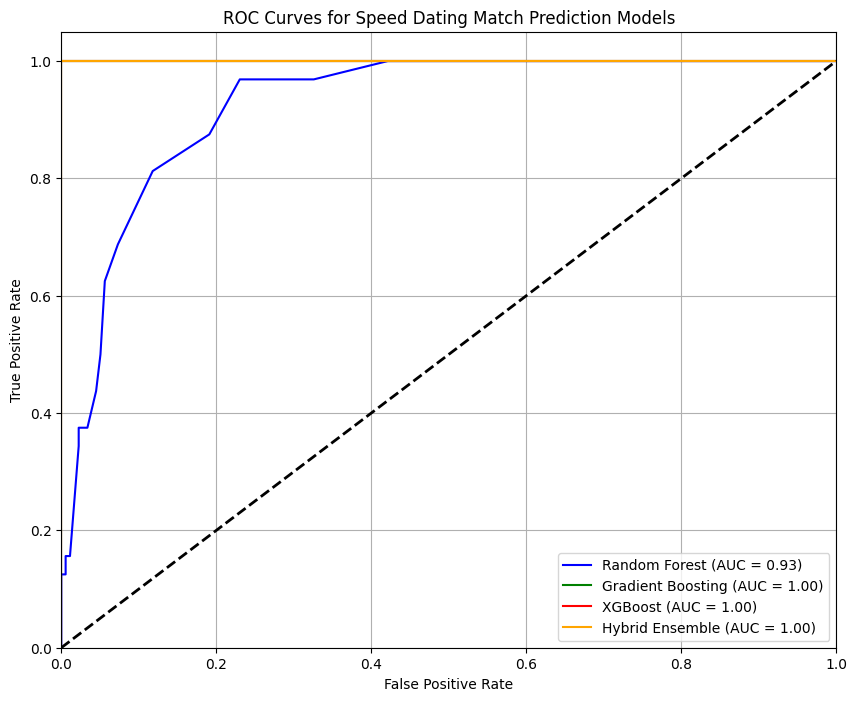

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import RocCurveDisplay

# Load your dataset here (assuming CSV)
df = pd.read_csv('/content/speeddate.csv',  encoding='latin-1')

# Prepare the dataset
df = df.sample(frac=0.1, random_state=0)
X = df.drop('match', axis=1)
y = df['match']

# Data Preprocessing pipeline
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler(with_mean=False))
        ]), X.select_dtypes(exclude=['object']).columns.tolist())
    ]
)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_processed = pipeline.fit_transform(X)

# Split the data
xtrain, xtest, ytrain, ytest = train_test_split(X_processed, y, test_size=0.25, random_state=0)

# Base models
rf = RandomForestClassifier(n_estimators=50, random_state=0)
gb = GradientBoostingClassifier(n_estimators=50, random_state=0)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=50)

# Train individual models
rf.fit(xtrain, ytrain)
gb.fit(xtrain, ytrain)
xgb.fit(xtrain, ytrain)

# Get ROC curve values
fpr_rf, tpr_rf, _ = roc_curve(ytest, rf.predict_proba(xtest)[:,1])
fpr_gb, tpr_gb, _ = roc_curve(ytest, gb.predict_proba(xtest)[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(ytest, xgb.predict_proba(xtest)[:,1])

# Stacking (Hybrid Ensemble Model)
stack = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('xgb', xgb)
    ],
    final_estimator=LogisticRegression(max_iter=500)
)
stack.fit(xtrain, ytrain)
fpr_stack, tpr_stack, _ = roc_curve(ytest, stack.predict_proba(xtest)[:,1])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC for each model
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(ytest, rf.predict_proba(xtest)[:,1]):.2f})', color='blue')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(ytest, gb.predict_proba(xtest)[:,1]):.2f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(ytest, xgb.predict_proba(xtest)[:,1]):.2f})', color='red')
plt.plot(fpr_stack, tpr_stack, label=f'Hybrid Ensemble (AUC = {roc_auc_score(ytest, stack.predict_proba(xtest)[:,1]):.2f})', color='orange')

# ROC curve formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Speed Dating Match Prediction Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Seperate ROC curve**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


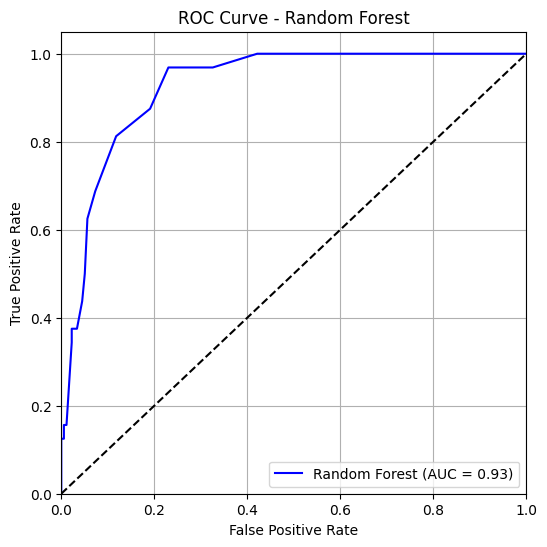

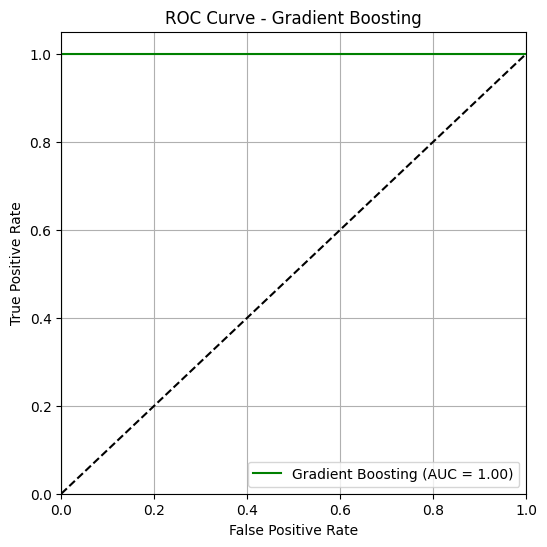

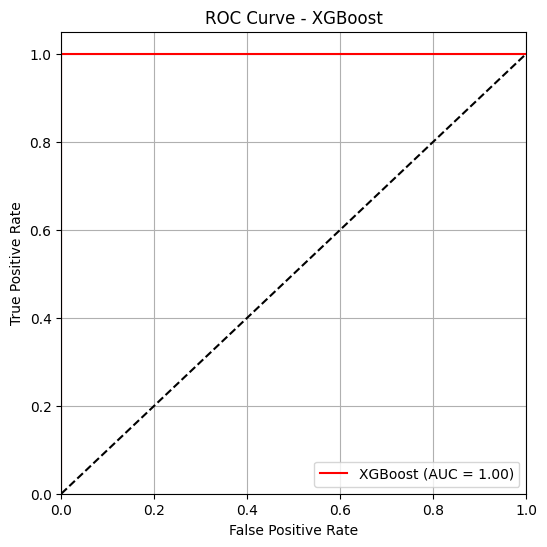

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:04:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


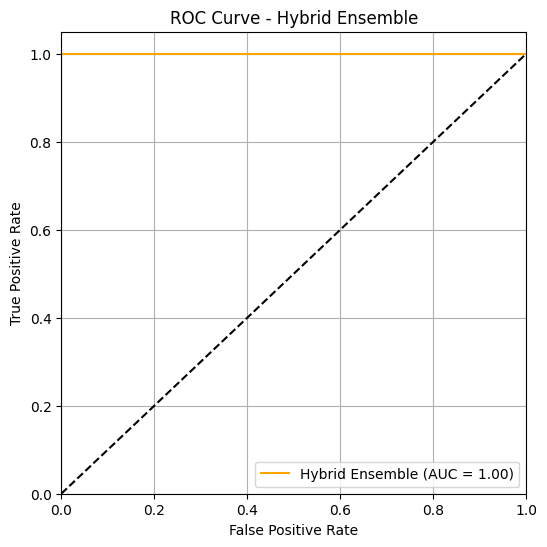

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import RocCurveDisplay

# Load your dataset here (assuming CSV)
df = pd.read_csv('/content/speeddate.csv',  encoding='latin-1')

# Prepare the dataset
df = df.sample(frac=0.1, random_state=0)
X = df.drop('match', axis=1)
y = df['match']

# Data Preprocessing pipeline
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler(with_mean=False))
        ]), X.select_dtypes(exclude=['object']).columns.tolist())
    ]
)
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_processed = pipeline.fit_transform(X)

# Split the data
xtrain, xtest, ytrain, ytest = train_test_split(X_processed, y, test_size=0.25, random_state=0)

# Base models
rf = RandomForestClassifier(n_estimators=50, random_state=0)
gb = GradientBoostingClassifier(n_estimators=50, random_state=0)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=50)

# Train individual models
rf.fit(xtrain, ytrain)
gb.fit(xtrain, ytrain)
xgb.fit(xtrain, ytrain)

# ROC Curves for each classifier separately

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(ytest, rf.predict_proba(xtest)[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(ytest, rf.predict_proba(xtest)[:, 1]):.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(ytest, gb.predict_proba(xtest)[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(ytest, gb.predict_proba(xtest)[:, 1]):.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(ytest, xgb.predict_proba(xtest)[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(ytest, xgb.predict_proba(xtest)[:, 1]):.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Hybrid Ensemble Model (Stacking)
stack = StackingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('xgb', xgb)],
    final_estimator=LogisticRegression(max_iter=500)
)
stack.fit(xtrain, ytrain)
fpr_stack, tpr_stack, _ = roc_curve(ytest, stack.predict_proba(xtest)[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(fpr_stack, tpr_stack, label=f'Hybrid Ensemble (AUC = {roc_auc_score(ytest, stack.predict_proba(xtest)[:, 1]):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Hybrid Ensemble')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
